In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn
pd.set_option('use_inf_as_na', True)
from collections import Counter

In [2]:
raw_data = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [3]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.01:
        return -1
    else:
    
        return 0

In [4]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [130]:
df_train = data.loc['2010-01-01':'2013-01-01']
df_valid = data.loc['2013-04-01':'2013-07-01']
df_test = data.loc['2013-10-01':'2014-01-01']

In [279]:
train = df_train.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                    'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [280]:
train_stock_returns = df_train['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

y_train = df_train['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

## Importing Optuna and suppressing warning messages

In [134]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

## Defining the Optuna objective function

In [135]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    rf_n_estimators = trial.suggest_int('n_estimators', 10,40,step=5)
    rf_max_features = trial.suggest_categorical('max_features',['sqrt','log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf',800,2400,step=800)
    rf_max_depth = trial.suggest_int('max_depth',4,15)
    
    rf_clf = RandomForestClassifier(n_estimators=rf_n_estimators,
                                    max_depth=rf_max_depth,
                                    min_samples_leaf=rf_min_samples_leaf,
                                    max_features=rf_max_features)
    rf_clf.fit(train,labels)
    accuracy = rf_clf.score(val,val_labels)
 
    return accuracy

In [136]:
study = optuna.create_study(direction="maximize")

In [11]:
from functools import partial

In [137]:
%%time
study.optimize(partial(objective,train=train,labels=y_1,val=valid,val_labels=y_valid,val_rets=valid_stock_returns), n_trials=200,n_jobs=-1)

CPU times: total: 48 s
Wall time: 34.1 s


In [138]:
study.best_params

{'n_estimators': 15,
 'max_features': 'log2',
 'min_samples_leaf': 1600,
 'max_depth': 5}

In [139]:
rf_clf = RandomForestClassifier(**study.best_params)

In [281]:
rf_clf.fit(train,y_train)

RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=1600,
                       n_estimators=15)

In [141]:
preds=rf_clf.predict(valid)

In [142]:
valid_profit = (preds * df_valid['next_period_return']).sum()
valid_profit

139.483124

In [143]:
pred_test=rf_clf.predict(test)

In [144]:
test_profit = (pred_test * df_test['next_period_return']).sum()
test_profit

96.83442900000003

In [145]:
confusion_matrix(y_test,pred_test)

array([[  0,   0, 827],
       [  0,   0, 164],
       [  0,   0, 883]], dtype=int64)

In [146]:
accuracy_score(preds,y_valid)

0.5125714285714286

In [147]:
accuracy_score(pred_test,y_test)

0.47118463180362863

In [148]:
len(train.columns)

725

In [149]:
def randomforest_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [282]:
fi = randomforest_feat_importances(rf_clf,train)

In [283]:
features = fi[(fi['feat_imp'] > 0.00)]

In [284]:
features.shape

(42, 2)

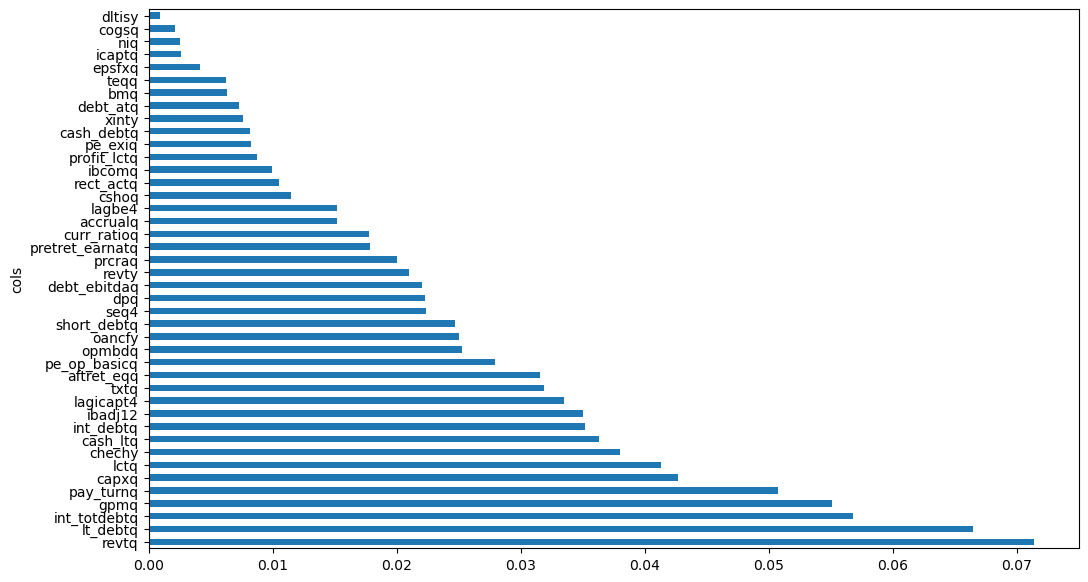

In [285]:
plot_fi(features);

In [286]:
features

,cols,feat_imp
51,revtq,0.071429
150,lt_debtq,0.066456
142,int_totdebtq,0.056795
112,gpmq,0.055133
172,pay_turnq,0.050791
153,capxq,0.042689
31,lctq,0.041329
66,chechy,0.038000
143,cash_ltq,0.036361
141,int_debtq,0.035170


In [287]:
train = train[features['cols'].values]
valid = valid[features['cols'].values]

In [288]:
rf_clf.fit(train,y_train)
rf_clf.score(train,y_train)

0.5018608009776149

In [289]:
len(valid)

1750

In [290]:
pred_valid = rf_clf.predict(valid)
rf_clf.score(valid,y_valid)

0.4634285714285714

In [291]:
(pred_valid * valid_stock_returns).sum()

92.73524999999998

In [160]:
Counter(pred_valid)

Counter({1: 1616, -1: 134})

In [161]:
valid_1 = valid.copy()

In [162]:
valid_1['returns'] = valid_stock_returns.values

In [163]:
import shap

In [164]:
def model(features):
    tree_features = features[features.columns[:-1].values]

    pred = rf_clf.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [165]:
model(valid_1)

0       0.003409
1      -0.006907
2       0.041883
3      -0.029884
4       0.128291
          ...   
1745   -0.119765
1746    0.153591
1747    0.108772
1748    0.137032
1749   -0.152459
Name: returns, Length: 1750, dtype: float64

In [166]:
explainer = shap.explainers.Permutation(model,valid_1)

In [167]:
shap_values = explainer(valid_1,max_evals=2000)

PermutationExplainer explainer: 1751it [12:05,  2.38it/s]                                                              


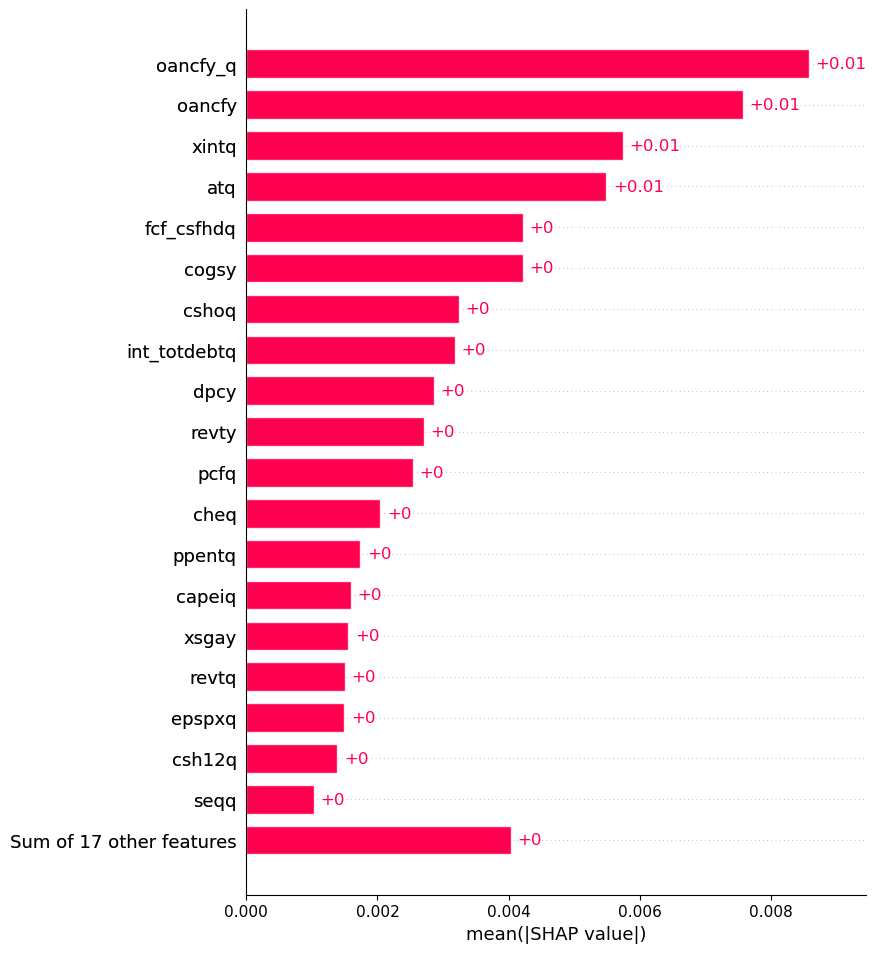

In [168]:
shap.plots.bar(shap_values[:,:-1],max_display=20)

In [169]:
cols = features['cols'].values

In [292]:
shap_cols = cols[np.abs(shap_values[:,:-1].values).mean(axis=0)>0.000]

In [293]:
len(shap_cols)

27

In [294]:
shap_cols

array(['dpcy', 'opepsq', 'oancfy_q', 'cshoq', 'cogsy', 'ibcy', 'xintq',
       'npmq', 'pcfq', 'atq', 'seqq', 'cheq', 'csh12q', 'fcf_csfhdq',
       'rect_turnq', 'int_totdebtq', 'oancfy', 'revty', 'ppentq', 'revtq',
       'intcov_ratioq', 'short_debtq', 'epspxq', 'oibdpy', 'gpmq',
       'xsgay', 'capeiq'], dtype=object)

In [295]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3 * i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=6):d+pd.DateOffset(months = 9)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
test_labels = [d['rel_performance'].values for d in test_frames]

In [296]:
from sklearn.preprocessing import StandardScaler

In [297]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(training_data))]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(test_data))]

In [298]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        rf_clf.fit(opt_training_data[i],training_labels[i])

        preds = rf_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)


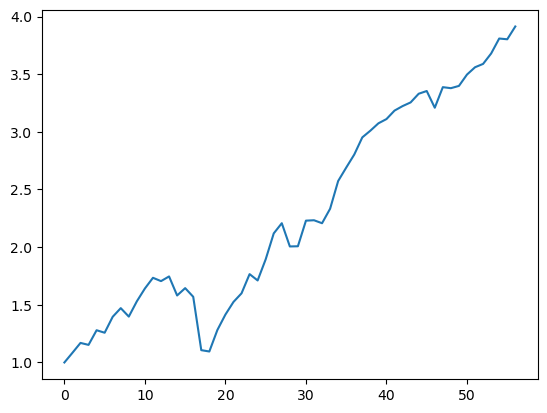

In [299]:
plt.plot(x);

In [300]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['strategy'] = x

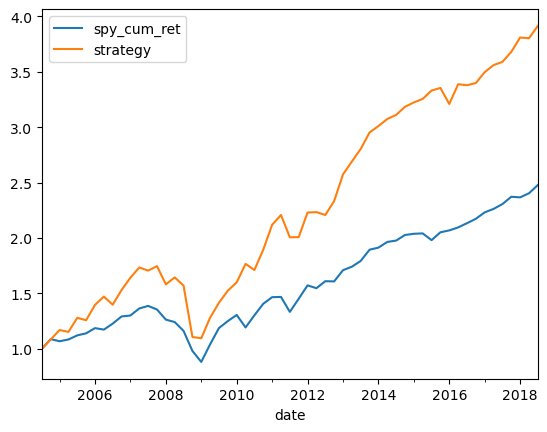

In [301]:
SPY.plot();

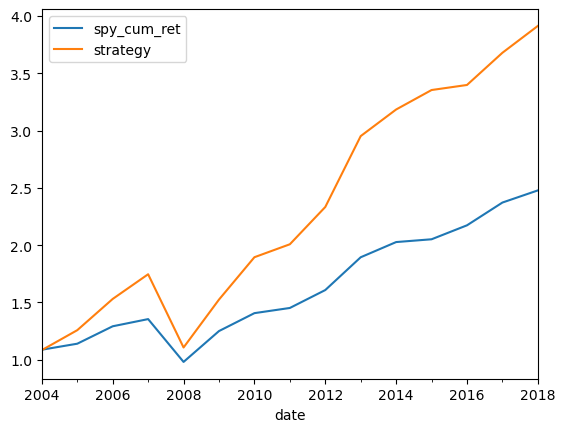

In [302]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [303]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.7216834030415598


In [304]:
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_std

0.28004861178600016

In [305]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SP Sharpe Ratio:  0.6324646748042165


In [306]:
x[-1]

3.913550978153994

In [307]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

1.8358576202709593

In [308]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

0.24202150707860198

In [309]:
alpha = np.mean(residual_ret)
alpha

0.019759483639310658

In [189]:
rf_clf.fit(train,y_train)
rf_clf.score(train,y_train)

0.4995834027662056

In [190]:
def profit_importance(m,df,rets):
#     np.random.seed(123)
    profit = []
    for col in df.columns:
        prof = []
        for _ in range(100):
            X = df.copy()
            X[col] = np.random.permutation(df[col].values)
            prediction = m.predict(X)
            prof.append((prediction * rets).sum())
        profit.append(np.mean(prof))
    return profit

In [191]:
def randomforest_profit_importance(m, df,rets):
    return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                       ).sort_values('pi_imp', ascending=True)

In [192]:
pi = randomforest_profit_importance(rf_clf,valid,valid_stock_returns)
pi

,cols,pi_imp
34,capeiq,113.180040
14,cheq,113.996007
30,oibdpy,117.004555
12,seqq,117.058762
8,npmq,117.244175
22,revty,117.302198
19,pe_exiq,117.302198
13,rd_saleq,117.302198
24,cash_ltq,117.302198
25,ppentq,117.302198


In [193]:
%%time
profits = []
feat=[]

train = train.copy()
validation = valid.copy()

while len(train.columns)>1:

    col_to_drop = pi.iloc[-1]['cols']
    train.drop(col_to_drop,axis=1,inplace=True)
    validation.drop(col_to_drop,axis=1,inplace=True)
        
    rf_clf.fit(train,y_1)
    pi = randomforest_profit_importance(rf_clf,validation,df_valid['next_period_return'])

    pred_valid = rf_clf.predict(validation)
        
    print((pred_valid * df_valid['next_period_return']).sum())
    profits.append((pred_valid * df_valid['next_period_return']).sum())
    feat.append(train.columns)

79.09163799999997
110.03632400000001
118.36014799999998
126.15557599999998
129.36978000000002
131.766868
135.154018
125.39699599999999
139.5824
136.742428
135.04541
134.011838
137.38397199999997
136.17772399999998
126.82307200000002
136.98933
123.561704
131.66708600000004
130.179592
139.148492
138.59783399999998
139.07432200000002
138.04681800000003
140.74975799999999
138.892556
130.30033400000002
117.11874800000001
120.57065600000001
140.191738
139.906758
125.02021200000001
124.82325600000001
126.79093
107.70986000000002
66.68877599999998
CPU times: total: 2min 1s
Wall time: 6min 24s


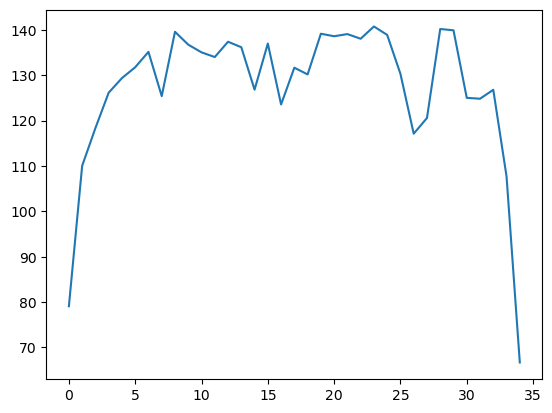

In [194]:
plt.plot(profits);

In [195]:
n = np.argmax(profits)
profits[n]

140.74975799999999

In [196]:
n

23

In [197]:
optim_feats = feat[n]
optim_feats


Index(['dpcy', 'npmq', 'seqq', 'rd_saleq', 'cheq', 'csh12q', 'aftret_eqq',
       'fcf_csfhdq', 'pe_exiq', 'dvq', 'ppentq', 'oibdpy'],
      dtype='object')

In [206]:
train_optim = train[optim_feats]
valid_optim = valid[optim_feats]


rf_clf.fit(train_optim,y_train)
print(rf_clf.score(train_optim,y_train))
pred_valid = rf_clf.predict(valid_optim)
print(rf_clf.score(valid_optim,y_valid))
(pred_valid * valid_stock_returns).sum()

0.5020274398711326
0.52


122.71457600000002

In [207]:
confusion_matrix(pred_valid,y_valid)

array([[ 74,   7,  61],
       [  0,   0,   0],
       [665, 107, 836]], dtype=int64)

In [75]:
Counter(y_valid)

Counter({1: 897, -1: 739, 0: 114})

In [76]:
Counter(pred_valid)

Counter({1: 1688, -1: 62})

## Long term performance with Random Forest Classifier, optimal hyper-parameters

In [208]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3 * i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [255]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 9):d+pd.DateOffset(months = 12)] for d in end_dates]

In [256]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [257]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [258]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [259]:
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [260]:
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)):
        rf_clf.fit(opt_training_data[i],training_labels[i])
        pred_i = rf_clf.predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

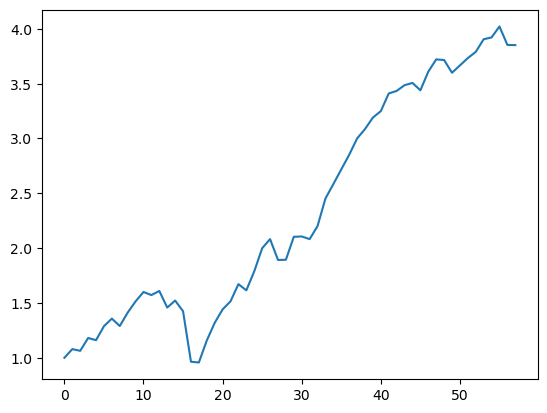

In [261]:
plt.plot(x);

In [262]:
len(x)

58

In [263]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2019-03-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

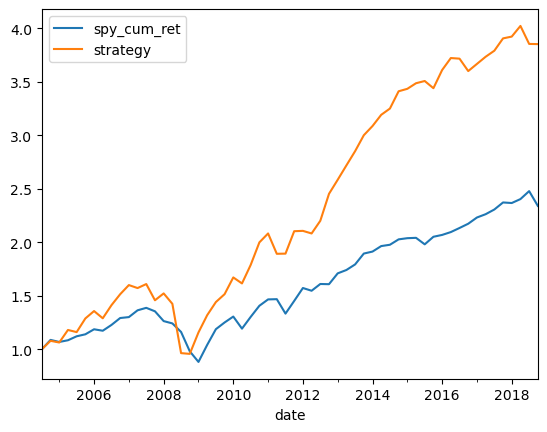

In [264]:
SPY.plot();

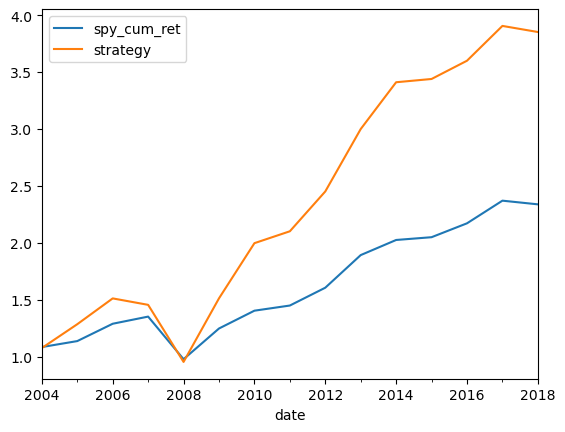

In [265]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [266]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.6905532878148939


In [267]:
x[-1]

3.8518669707893554

In [268]:
SPY['spy_cum_ret'][-1]

2.3397169999999994

In [269]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [270]:
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]

In [271]:
beta

1.7927046570159701

In [272]:
residual_ret = strategy_ret - beta * spy_ret

In [273]:
IR = np.mean(residual_ret)/np.std(residual_ret)

In [274]:
IR

0.3737075706618738

In [275]:
alpha = np.mean(residual_ret)

In [276]:
alpha

0.037707478349882195

In [ ]:
def max_drawdown(returns):
        local_max = [n for n in range(len(returns)-1) if ((n==0) and (returns[0] > returns[1])) or 
           ((n > 0) and  (returns[n-1]<returns[n]) and (returns[n+1]<returns[n]))] 
        
        local_min = [n for n in range(1,len(returns)) if ((n == len(returns)-1) and (returns[-1] < returns[-2])) or
                (returns[n-1]>returns[n]) and (returns[n+1]>returns[n])]
        
        def next_local_min(n):
            if [m for m in local_min if m > n]:
                return [m for m in local_min if m > n][0]
            else: return None
        
        drawdowns = [(n,next_local_min(n)) for n in local_max]
        drawdown_values = [returns[n] - returns[m] for (n,m) in drawdowns if m != None]
        if drawdown_values:
            return  np.max(drawdown_values)
        else: return 0.0

In [ ]:
max_drawdown(SPY['strategy'])

In [ ]:
max_drawdown(SPY['spy_cum_ret'])